# Problem Set 2 - Naive Bayes, Decision Trees with ensemble methods
## CSCI 4622 - Fall 2021
***
**Name**: $Tamer Shahwan$ 
***

This assignment is due on Canvas by **1:50PM on October 6th**.

Submit only this Jupyter notebook to Canvas. Do not compress it using tar, rar, zip, etc.
Your solutions to analysis questions should be done in Markdown directly below the associated question.

Remember that you are encouraged to discuss the problems with your classmates and instructors, 
but **you must write all code and solutions on your own**, and list any people or sources consulted.
The only exception to this rule is that you may copy code directly from your own solution to homework 1.
***

## Overview 

Your task for this homework is to build a naive Bayes and a decision tree classifiers in the first 2 problems.
The last problem is about ensemble methods using scikit-learn decision tree as a weak learner.
We'll explore bagging, boosting (AdaBoost) and Random Forest.

In [1]:
import numpy as np
import matplotlib.pylab as plt
import pickle
from sklearn.metrics import precision_score
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from time import time
import math
%matplotlib inline 
#additional imports to play with dictionaries
from collections import Counter
import operator


In C:\Users\Tamer\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Tamer\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Tamer\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Tamer\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Tamer\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

### Problem 1 - Naive Bayes [25 points]
***
Consider the problem of predicting whether a person has a college degree based on age, salary, and Colorado residency.
The dataset looks like the following.

|Age|Salary|Colorado Residency| College degree|
|:------:|:-----------:| :----------:|--:|
| 27 | 41,000 | Yes | Yes |
| 61 | 52,000 | No | No |
| 23 | 24,000 | Yes | No |
| 29 | 77,000 | Yes | Yes |
| 32 | 48,000 | No | Yes |
| 57 | 120,000 | Yes | Yes |
| 22 | 38,000 | Yes | Yes |
| 41 | 45,000 | Yes | No |
| 53 | 26,000 | No | No |
| 48 | 65,000 | Yes | Yes |


In [2]:
features = np.array([[27 , 41000 , 1],
              [61 , 52000 , 0],
              [23 , 24000 , 1],
              [29 , 77000 , 1],
              [32 , 48000 , 0],
              [57 , 120000 , 1],
              [22 , 38000 , 1],
              [41 , 45000 , 1],
              [53 , 26000 , 0],
              [48 , 65000 , 1]])
labels = np.array([1, 0, 0, 1, 1, 1, 1, 0, 0, 1])

1.1 What is our expected accuracy for the baseline case where we predict one label for all rows? (*2 points*)

## BEGIN Workspace 1.1

accuracy of the baseline using no features is equal to (number of time we predit that label divided by the total).
For example if for college degree we predit yes for all rows, then 6/10 =.6 accuracy.


First, we have to find a way to deal with the continuous features. For now, let's put them into binary bins based on threshold arguments to our classifier - so we can treat this as a tuning parameter.

1.2 Complete `threshold_features` to convert age and salary features to binary ones using the threshold arguments. (*3 points*)

In [3]:
def threshold_features(features, age_threshold, salary_threshold):
    binary_X = features * 1 #This row just creates a "hard copy" of the X array so we can manipulate it as needed
    #BEGIN Workspace 1.2
    #TODO: Threshold the corresponding features
    for i in range(len(features)):
        #case to check on age, 1 if bigger or equal to threshold and 0 if not
        if(features[i][0] >=age_threshold):
            binary_X[i][0] = 1
        else:
            binary_X[i][0] = 0
        #case to check on salary, 1 if bigger or equal to threshold and 0 if not
        if(features[i][1] >= salary_threshold):
            binary_X[i][1] = 1
        else:
            binary_X[i][1] = 0
            
    #END Workspace 1.2

    return binary_X

In [4]:
new_features = threshold_features(features, 30, 50000)
print(new_features)

[[0 0 1]
 [1 1 0]
 [0 0 1]
 [0 1 1]
 [1 0 0]
 [1 1 1]
 [0 0 1]
 [1 0 1]
 [1 0 0]
 [1 1 1]]


As seen during the class, given a row $(x_1, x_2, x_3)$, the naive Bayes classifier should assign the label $y$ that
maximizes:

\begin{align}
\log [p(y) \prod_i p(x_i | y)] = \log p(y) + \sum_{i} \log p(x_i | y)
\end{align}

$p(y)$ and $p(x_i | y)$ are computed using the training set (during `fit` call).

We have defined $p(x_i | y)$ as :
\begin{align}
p(x_i | y) = \frac{N_{y,i}}{N_y}
\end{align}
where $N_{y,i}$ is the number of rows where $y$ and $x_i$ occur together, and $N_y = \sum_i N_{y,i}$.

1.3 Complete the `fit` call by computing the counts and joint counts. Hint: Use `features_counts` to store the contingency
table $N_{y,i}$ for each feature $i$ and then use them to compute $\log p(x_i | y)$ (*10 points*)

1.4 Complete the `predict` call (*5 points*)

In [27]:
class NaiveBayes(object):
    """
    NaiveBayes classifier for binary features and binary labels
    """

    def __init__(self, alpha=0.0):
        self.alpha = alpha
        self.classes_counts = {}
        self.features_counts = {}
        self.classes_log_probabilities = {}
        self.features_log_probabilities = {} #note i changed this from [] to {}
        
    def fit(self, X, y):
        """

        Parameters
        ----------
        X: binary np.array of shape (n_samples, n_features)
        y: corresponding labels of shape (n_samples,)
        Returns
        -------
        Trained classifier
        """

        #BEGIN Workspace 1.3

        #TODO: Compute the counts and joint counts
        #First lets count the classes.
        unique_classes = np.unique(y)
        #initilize step
        for label in unique_classes:
            self.classes_counts[label]=0
        #count step
        for label in y:
            self.classes_counts[label] =self.classes_counts[label] +1
            
        #now time to count p(xi|y)
        #we know our data can only be either 0 or 1 (young or old, poor or rich...)
        for i in range(1,len(X[0])+1):
            for label in unique_classes:
                #if i is zero then make it negative, if i is 1 then make it positive
                self.features_counts[(-i,label)] =0
                self.features_counts[(i,label)] =0

        #lets count for self.features_counts
        for row_index in range(len(X)):
            for i in range(1,len(X[row_index])+1):
                element_index = i-1
                if X[row_index][element_index] == 0:
                    self.features_counts[(-i,y[row_index])] = self.features_counts[(-i,y[row_index])] +1
                elif X[row_index][element_index] == 1:
                    self.features_counts[(i,y[row_index])] = self.features_counts[(i,y[row_index])] +1

        #get features_counts totals for each class (0,1)
        features_counts = self.features_counts
        total_0 = 0
        total_1 = 0
        for x in features_counts:
            if x[1] == 0:
                total_0 = total_0 +features_counts[x] 
            if x[1] == 1:
                total_1 = total_1 +features_counts[x] 
        # compute log probabilities
        for x in features_counts:
            if x[1] == 0:
                self.features_log_probabilities[x] = np.log((features_counts[x]/total_0))
            elif x[1] == 1:
                self.features_log_probabilities[x] = np.log(features_counts[x]/total_1)

        #compute log probability of each class
        classes_counts = self.classes_counts
        for x in classes_counts:
            self.classes_log_probabilities[x] = math.log(classes_counts[x]/sum(classes_counts.values()))
            

        return self

    def predict(self, x_test):
        # sum the feature log probabilities for each class
        log_total= [0,0]

        features_log_probabilities = self.features_log_probabilities
        for x in features_log_probabilities:
            if x[1] == 0:
                log_total[0] = log_total[0] + features_log_probabilities[x]
            elif x[1] == 1:
                log_total[1] = log_total[1] + features_log_probabilities[x]
        
        joint_log_likelihood = np.zeros((3, 2))
        #joint_log_likelihood = np.zeros((x_test.shape[0], self.classes_counts.shape[0]))
        y_hat = 0
        #BEGIN Workspace 1.4
        #TODO: Find the corresponding labels using Naive bayes logic
        final_predict =[]
        for x in range(len(x_test)):
            predict_row = []
            for label in self.classes_log_probabilities:
                total_right =0
                for col in range(np.shape(x_test)[1]):
                    if x_test[x][col] == 0:
                        key =  -(col+1)
                    elif x_test[x][col] == 1:
                        key =  col+1
                    for y in features_log_probabilities:
                        if y[1] == label:
                            if y[0] == key:
                                total_right = total_right + features_log_probabilities[y]
                
                predict_row.append(self.classes_log_probabilities[label]+total_right)
            final_predict.append(predict_row.index(max(predict_row)))

        return final_predict


1.5 Using age 30 and salary 40,000 as thresholds, transform the features and evaluate (accuracy) the NaiveBayes classifier
on the training data. (*5 points*)

In [28]:
#BEGIN Workspace 1.5
#TODO: Transform features to binary features, fit the classifier, report the accuracy
new_features = threshold_features(features, 30, 40000)
model = NaiveBayes()
model =model.fit(new_features,labels)
result =model.predict(new_features)
print('given labels:',labels)
print("prediction result:", result)
correct_predict = 0
for i in range(len(result)):
    if result[i] == labels[i]:
        correct_predict = correct_predict + 1
print('Accuracy:', correct_predict/len(result))
#END Workspace 1.5

given labels: [1 0 0 1 1 1 1 0 0 1]
prediction result: [1, 0, 1, 1, 0, 1, 1, 1, 0, 1]
Accuracy: 0.7


**Bonus question** 1.6 Use the attribute `alpha` of the NaiveBayes to convert it to the smoothed NaiveBayes presented during the class. (*5 points*)

Solution: I copy my solution above and modified it.specifically changed lines 69,71 and 76.

In [29]:
class NaiveBayes_smoothed(object):
    """
    NaiveBayes classifier for binary features and binary labels
    """

    def __init__(self, alpha=0.0):
        self.alpha = alpha
        self.classes_counts = {}
        self.features_counts = {}
        self.classes_log_probabilities = {}
        self.features_log_probabilities = {} #note i changed this from [] to {}
        
    def fit(self, X, y):
        
        """
        Parameters
        ----------
        X: binary np.array of shape (n_samples, n_features)
        y: corresponding labels of shape (n_samples,)
        Returns
        -------
        Trained classifier
        """

        #BEGIN Workspace 1.3

        #TODO: Compute the counts and joint counts
        #First lets count the classes.
        unique_classes = np.unique(y)
        #initilize step
        for label in unique_classes:
            self.classes_counts[label]=0
        #count step
        for label in y:
            self.classes_counts[label] =self.classes_counts[label] +1
            
        #now time to count p(xi|y)
        #we know our data can only be either 0 or 1 (young or old, poor or rich...)
        for i in range(1,len(X[0])+1):
            for label in unique_classes:
                #if i is zero then make it negative, if i is 1 then make it positive
                self.features_counts[(-i,label)] =0
                self.features_counts[(i,label)] =0

        #lets count for self.features_counts
        for row_index in range(len(X)):
            for i in range(1,len(X[row_index])+1):
                element_index = i-1
                if X[row_index][element_index] == 0:
                    self.features_counts[(-i,y[row_index])] = self.features_counts[(-i,y[row_index])] +1
                elif X[row_index][element_index] == 1:
                    self.features_counts[(i,y[row_index])] = self.features_counts[(i,y[row_index])] +1

        #get features_counts totals for each class (0,1)
        features_counts = self.features_counts
        total_0 = 0
        total_1 = 0
        for x in features_counts:
            if x[1] == 0:
                total_0 = total_0 +features_counts[x] 
            if x[1] == 1:
                total_1 = total_1 +features_counts[x] 
                
        # compute log probabilities
        for x in features_counts:
            if x[1] == 0:
                self.features_log_probabilities[x] = np.log(((features_counts[x]+1)/(total_0+len(unique_classes))))
            elif x[1] == 1:
                self.features_log_probabilities[x] = np.log((features_counts[x]+1)/(total_1+len(unique_classes)))

        #compute log probability of each class
        classes_counts = self.classes_counts
        for x in classes_counts:
            self.classes_log_probabilities[x] = math.log(classes_counts[x]+1/sum(classes_counts.values())+len(unique_classes))
            

        return self

    def predict(self, x_test):
        # sum the feature log probabilities for each class
        log_total= [0,0]

        features_log_probabilities = self.features_log_probabilities
        for x in features_log_probabilities:
            if x[1] == 0:
                log_total[0] = log_total[0] + features_log_probabilities[x]
            elif x[1] == 1:
                log_total[1] = log_total[1] + features_log_probabilities[x]
        
        joint_log_likelihood = np.zeros((3, 2))
        #joint_log_likelihood = np.zeros((x_test.shape[0], self.classes_counts.shape[0]))
        y_hat = 0
        #BEGIN Workspace 1.4
        #TODO: Find the corresponding labels using Naive bayes logic
        final_predict =[]
        for x in range(len(x_test)):
            predict_row = []
            for label in self.classes_log_probabilities:
                total_right =0
                for col in range(np.shape(x_test)[1]):
                    if x_test[x][col] == 0:
                        key =  -(col+1)
                    elif x_test[x][col] == 1:
                        key =  col+1
                    for y in features_log_probabilities:
                        if y[1] == label:
                            if y[0] == key:
                                total_right = total_right + features_log_probabilities[y]
                
                predict_row.append(self.classes_log_probabilities[label]+total_right)
            final_predict.append(predict_row.index(max(predict_row)))

        return final_predict


In [30]:
#smoothed version
new_features = threshold_features(features, 30, 40000)
model = NaiveBayes_smoothed()
model =model.fit(new_features,labels)
result =model.predict(new_features)
print('given labels:',labels)
print("prediction result:", result)
correct_predict = 0
for i in range(len(result)):
    if result[i] == labels[i]:
        correct_predict = correct_predict + 1
print('Accuracy:', correct_predict/len(result))

given labels: [1 0 0 1 1 1 1 0 0 1]
prediction result: [1, 0, 1, 1, 0, 1, 1, 1, 0, 1]
Accuracy: 0.7


### Problem 2 - Decision trees [25 points]
***
The goal of this problem is to implement the core elements of the Decision Tree classifier.
We do not expect a highly efficient implementation of the functions since the ensemble methods will use the implementation
from scikit-learn.

We start by considering the variable *Colorado residency*.

The leaf nodes of a decision tree act in the same way as in question (1.1) where no feature is used.

2.1 Complete `get_error_in_leaf` to return the count of misclassified instances. (*3 points*)

In [31]:
def get_error_in_leaf(y, indices):
    """
    :param y: all labels
    :param indices: the subset of indexes in the leaf node
    :return: Returns the number of errors in a leaf node of a decision tree.
    """
    classes_counts = {}
    unique_classes = np.unique(y)
    #initilize step
    for label in unique_classes:
        classes_counts[label]=0
        
    for i in indices:
        
        classes_counts[y[i]] = classes_counts[y[i]] +1
        

    error_count = classes_counts[0]
    #BEGIN Workspace 2.1
    #TODO: Compute the number of errors in the leaf node (no feature is used)
    
    #END Workspace 2.1
    return error_count


def value_split_binary_feature(x, y, feature_index, root, criteria_func):
    """Will be used later to evaluate the criteria gain"""
    left_child = [i for i in root if x[i, feature_index] == 0]
    right_child = [i for i in root if x[i, feature_index] == 1]
    return criteria_func(y, root, left_child, right_child)


In [32]:
labels = np.array([1, 0, 0, 1, 1, 1, 1, 0, 0, 1])
get_error_in_leaf(labels, [2,3,4])

1

We will use information gain criteria to decide how to split the root node of our decision tree.

2.2 Complete the `entropy` function. (*5 points*)

2.3 Complete the `information_gain_criteria` to compute the information gained by splitting the root node.
 Print the gain value for splitting based on *Colorado residency* (*5 points*)


In [33]:
def entropy(y, indices):
    """
    :param y: all labels
    :param indices: the indices of data points
    :return: Returns the entropy in the labels for the data points in indices.
    """
    percent_lst = []
    classes_counts = {}
    unique_classes = np.unique(y)
    #initilize step
    for label in unique_classes:
        classes_counts[label]=0
        
    entropy_value = 0
    if len(indices) == 0: # deal with corner case when there is no data point.
        return entropy_value
    else:
        #BEGIN Workspace 2.2
        #TODO: Compute the entropy of the labels from indices
        for i in indices:
            classes_counts[y[i]] = classes_counts[y[i]] + 1 
        for i in classes_counts:
            percent_lst.append((classes_counts[i]/sum(classes_counts.values())))

        #now calculate entrpoy
        for i in percent_lst:
            entropy_value = entropy_value - (i * np.log2(i))
        #END Workspace 2.2
    return entropy_value

def information_gain_criteria(y, root, left_child, right_child):
    """
    :param y: all labels
    :param root: indices of all the data points in the root
    :param left_child: the subset of indices in the left child
    :param right_child: the subset of indices in the right child
    :return: information gain of the split
    """
    information_gain = 0
    #BEGIN Workspace 2.3.a
    #TODO: Compute the information gain of the split
    i_dpar =entropy(y,root)
    i_dright= entropy(y,right_child)
    i_dleft=entropy(y,left_child)
    dpar_size = len(root)
    dright_size = len(right_child)
    dleft_size = len(left_child)
    information_gain = (i_dpar - ((dleft_size/dpar_size) * i_dleft) - ((dright_size/dpar_size) * i_dright))
    #END Workspace 2.3.a

    return information_gain

In [34]:
feature_id = 2
info_gain = 0 
#BEGIN Workspace 2.3.b
#TODO: report the information gain of the split based on Colorado Residency

print('Entropy test:',entropy(labels, [2,3,4]))
root = []
#make the root node as tuples example: (colorado_residency,has_degree)
for i in range(len(new_features)):
    root.append((new_features[i][feature_id],labels[i]))
#branch off of colorado residency status
left_child,right_child =[],[]
for i in range(len(root)):
    if root[i][0] == 0:
        left_child.append(i)
    elif root[i][0] == 1:
        right_child.append(i)
print('Information gain test:',information_gain_criteria(labels, [0,1,2,3,4,5,6,7,8,9], left_child, right_child))
      
#END Workspace 2.3.b

Entropy test: 0.9182958340544896
Information gain test: 0.0912774462416801


Now we have to deal with continuous features for the decision tree.
One way to deal with continuous (or ordinal) data is to define binary features based on thresholding as we've done
for NaiveBayes. But we have to find the optimal threshold based on the criteria we're using.

2.4 Complete the `value_split_continuous_feature` by trying different possible threshold values of feature
of index `feature_index` and return the best criteria value and threshold. (*5 points*)

In [35]:
def value_split_continuous_feature(x, y, feature_index, root, criteria_func=information_gain_criteria):
    """
    :param x: all feature values
    :param y: all labels
    :param feature_index: feature id to split the tree based on
    :param root: indexes of all the data points in the root
    :param criteria_func: the splitting criteria function
    :return: Return the best value and its corresponding threshold by splitting based on a continuous feature.
    """
    all_values = {}

    best_value, best_thres = 0, 0
    feature_values = []
    for row in x:
        feature_values.append(row[feature_index])
    index = 0
    for split in feature_values:
        counter = 0
        left_child,right_child = [],[]
        for value in feature_values:
            if value > split:
                right_child.append(counter)
            elif value <= split:
                left_child.append(counter)
            counter= counter +1
        all_values[index]=criteria_func(y,root,left_child,right_child)
        index = index +1
    best_value = max(all_values.values())
    for key in all_values:
        if all_values[key] == best_value:
            best_thres = feature_values[key]



    return best_value, best_thres

In [36]:
root = [x for x in range(len(features))]
value_split_continuous_feature(features, labels, 0, root)


C:\Users\Tamer\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
C:\Users\Tamer\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


(0.12451124978365313, 32)

2.5 Find the best thresholds for age and salary. Print their corresponding information gains. (*5 points*)

In [37]:
root = list(range(len(labels))) # root includes all data points

#BEGIN Workspace 2.5
#TODO: Report the best thresholds for age and salary and their split information gains
age_index = 0
salary_index = 1
print('Age best split:',value_split_continuous_feature(features, labels, age_index, root))
print('Age best split:',value_split_continuous_feature(features, labels, 2, root))

print('Salary best split:',value_split_continuous_feature(features, labels, salary_index, root))
#END Workspace 2.5

Age best split: (0.12451124978365313, 32)
Age best split: (0.0912774462416801, 0)
Salary best split: (0.12451124978365313, 45000)


C:\Users\Tamer\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
C:\Users\Tamer\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


2.6 Based on the obtained information gains, if we build a decision stump (decision tree with depth 1) greedily,
which feature should we choose? Why? What's the resulting accuracy? (*2 points*)

#BEGIN Workspace 2.6.a

Based on the information gains we choose either split age or salary because they have higher information gain(they are equal). For the salary split we get higher accuracy so it would be better to split on it

#END Workspace 2.6.a

In [38]:
#BEGIN Workspace 2.6.b

labels = np.array([1, 0, 0, 1, 1, 1, 1, 0, 0, 1])
new_features = threshold_features(features, 32, 45000)
counter  =0
for x in range(len(new_features)): 
    val = new_features[x][2]
    #print(val)
    if val == labels[x]:
        counter = counter +1
print(counter/len(labels))
#get_error_in_leaf(labels, [2,3,4])
#BEGIN Workspace 2.6.b

0.7


**Bonus Question**

2.7 You now have all the ingredients to build a decision tree recursively.
You can build a decision tree of depth two and report its classification error on the training data and the tree.(*5 points*)

In [18]:
#BEGIN Workspace 2.7
#TODO: Build a Decision Tree of Depth 2 using age, salary and the previously computed thresholds


#END Workspace 2.7

Problem 3  - Decision Tree Ensembles: Bagging and (BONUS: Boosting) [50 points]
---

We are going to predict house price levels using decision tree ensembles.

In this classification problem, we compare Decision trees and it's ensembles - Bagging and Boosting on House Price prediction [dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

Our *weak learner* for this problem is the DecisionTreeClassifier from scikit-learn with `max_depth=10`.

We start first by loading preprocessed data that we'll use. Since the original data is for regression, we have first to transform
`y_train` and `y_test` to discrete values reflecting price level.

|Price range| Label|
|:----------:|--:|
| $ P < $125000|0|
|125000$\leq P < $ 160000| 1 |
|160000$ \leq P < $ 200000| 2 |
|200000$ \leq P $ | 3 |

3.1 Start by transforming`y_train` and `y_test` to discrete values using the provided ranges. (*3 points*)

In [39]:
X_train, X_test, y_train, y_test = pickle.load(open('./data/test_train.pkl','rb'))
#BEGIN Workspace 3.1
#TODO: Discretize y_train and y_test
for index in range(len(y_train)):
        if y_train[index] < 125000:
            y_train[index] = 0
        elif y_train[index] >= 125000 and y_train[index] < 160000:
            y_train[index] = 1
        elif y_train[index] >= 160000 and y_train[index]< 200000:
            y_train[index] = 2
        elif y_train[index] >= 200000:
            y_train[index]= 3
for index in range(len(y_test)):

        if y_test[index] < 125000:
            y_test[index] = 0
        elif y_test[index] >= 125000 and y_test[index] < 160000:
            y_test[index] = 1
        elif y_test[index] >= 160000 and y_test[index]< 200000:
            y_test[index] = 2
        elif y_test[index] >= 200000:
            y_test[index]= 3

#END Workspace 3.1
print(np.unique(y_train), X_train.shape)
print(np.unique(y_test), X_test.shape)

[0 1 2 3] (1166, 79)
[0 1 2 3] (292, 79)


3.2 Complete the `ensemble_test` class to `fit` the model received as parameter and store the metrics and running time. (*5 points*)

3.3 Complete `plot_metric` to show and compare different statistics of each model in a bar chart. (*5 points*)

Later we will also use `ensemble_test` class to plot score, metric and time taken to fit the data.

In [41]:
def get_weak_learner():
    """Return a new instance of out chosen weak learner"""
    return DecisionTreeClassifier(max_depth=10)

class EnsembleTest:
    """
        Test multiple model performance
    """

    def __init__(self, x_train, y_train, x_test, y_test):
        """
        initialize data partitions
        """
        self.scores = {}
        self.execution_time = {}
        self.metric = {}
        self.x_train = X_train
        self.y_train = y_train
        self.x_test = X_test
        self.y_test = y_test
        self.score_name ='Mean accuracy'
        self.metric_name = 'Precision(micro)'

    def fit_model(self, model, name):
        """
        Fit the model on train data.
        predict on test and store score and execution time for each fit.
        :param model: model
        :param name: name of model
        """
        start = time()
        #BEGIN Workspace 3.2
        #TODO: Fit the model and get the predictions
        #train and test data are treated as global variables
        
        #model = DecisionTreeClassifier(model)
        model =model.fit(self.x_train,self.y_train)
        prediction= model.predict(self.x_test)
        #get precision
        self.scores[name] = precision_score(prediction,self.y_test,average="micro")
        #get accuracy
        counter = 0
        for x in range(len(prediction)):
            if prediction[x] == self.y_test[x]:
                counter = counter +1
        self.metric[name]=counter/len(self.y_test)

        #END Workspace 3.2
        self.execution_time[name] = time() - start

    def print_result(self):
        """
            print results for all models trained and tested.
        """
        models_cross = pd.DataFrame({
            'Model'         : list(self.metric.keys()),
             self.score_name     : list(self.scores.values()),
             self.metric_name    : list(self.metric.values()),
            'Execution time': list(self.execution_time.values())})
        print(models_cross.sort_values(by=self.score_name, ascending=False))

    def plot_metric(self):
        #BEGIN Workspace 3.3
        #TODO: plot bar chart for each metric : time, metric, score
        names = []
        accuracy = []
        precision =[]
        time = []
        for name in self.scores:
            names.append(name)
            accuracy.append(self.scores[name])
        for name in self.metric:
            precision.append(self.metric[name])
        for name in self.execution_time:
            time.append(self.execution_time[name])
        # Initialize figure and axis
        #fig, ax = plt.subplots(figsize=(8,4))
        N = len(names)

        ind = np.arange(N) 
        width = 0.30     
        plt.bar(ind, accuracy, width, label='Accuracy')
        plt.bar(ind + width, precision, width,label='Precision')
        plt.bar(ind + width+width, time, width,label='time')
        plt.ylabel('Results')
        plt.title('Results By Model')

        plt.xticks(ind + (width*2) / 2,names)
        plt.legend(loc='best')
        plt.show()

        #END Workspace 3.3

3.4 Test `EnsembleTest` using our weak learner returned by `get_weak_learner` (*2 points*)

    Model  Mean accuracy  Precision(micro)  Execution time
0  model1       0.678082          0.678082        0.027089
1  model2       0.671233          0.671233        0.020946


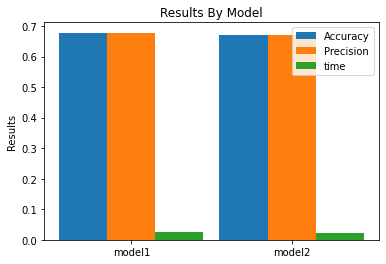

In [42]:
# create a handler for ensemble_test, use the created handler for fitting different models.
ensemble_handler = EnsembleTest(X_train,y_train,X_test,y_test)
#BEGIN Workspace 3.4
#TODO: Initialize weak learner and fit ensemble_handler

model = get_weak_learner()
model2 = get_weak_learner()
ensemble_handler.fit_model(model,'model1')
ensemble_handler.fit_model(model2,'model2')


ensemble_handler.print_result()
ensemble_handler.plot_metric()
#END Workspace 3.4


**Bagging:**

Bagging consists of training a set of weak learners using random subsets of the train data.

3.5 First, complete `sample_data` to return a random sample of size `sample_ratio * len(X_train)` of features and labels (*2 points*)

3.6 Complete `fit` by building `n_estimators` of DecisionTreeClassifier, each trained on random sample of the data (*5 points*)

3.7 Complete `predict` method to return the most likely label by combining different estimators predictions. 
Use a simple majority / plurality vote system similar to the one used in your KNNClassifier in Problem Set 1. However, in this case, to break a tie you should use `predict_log_proba` or `predict_proba` method of DecisionTreeClassifier:
[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.predict_proba) (*2 points*)

In [43]:
class BaggingEnsemble(object):

    def __init__(self, n_estimators, sample_ratio):
        self.n_estimators = n_estimators
        self.sample_ratio = sample_ratio
        self.estimators = []

    def sample_data(self, x_train, y_train):
        x_sample, y_sample = [], []
        #BEGIN Workspace 3.5
        #TODO: sample random subset of size sample_ratio * len(X_train)
        total = len(x_train)
        size = round(self.sample_ratio * total)
        index_lst = [index for index in range(total)]
        for i in range(size):        
            #randomly select an index
            choice = np.random.choice(index_lst,)
            #Once we randomly select an index, append its element to the proper list.
            x_sample.append(x_train[choice])
            y_sample.append(y_train[choice])
            # Manually remove the selected index so its not picked again
            #index_lst.remove(choice)

        #END Workspace 3.5
        return x_sample, y_sample

    def fit(self, x_train, y_train):
        for i in range(self.n_estimators):
            #BEGIN Workspace 3.6
            #TODO: sample data and create new weak learned trained on the sample
            x_sample,y_sample = self.sample_data(x_train,y_train)
            model = get_weak_learner()
            #model_name = 'model'+i
            model =model.fit(x_sample,y_sample)
            self.estimators.append(model)
            #ensemble_handler.fit_model(model,'model')
            #END Workspace 3.6

    def predict(self, X_test):
        predicted_proba = 0
        answer = []
        #BEGIN Workspace 3.7
        prediction_lst = []
        #TODO: go through the trained estimators and acummualte their predicted_proba to get the mostly likely label
        for model in self.estimators:
            prediction_lst.append(model.predict(X_test))
            
            
        for i in range(len(X_test)):
            holder_lst = []
            holder_count = {}

            for model in prediction_lst:
                            
                holder_lst.append(model[i])
            unique = np.unique(holder_lst)
            for i in unique:
                holder_count[i] = 0
            for i in holder_lst:
                holder_count[i] = holder_count[i] + 1
                
            answer.append(max(holder_count.items(), key=operator.itemgetter(1))[0])
        #END Workspace 3.7
        return answer


In [44]:
# This cell should run without errors
models = BaggingEnsemble(10, 0.9)
models.fit(X_train,y_train)
print(models.predict(X_test))

#ensemble_handler.fit_model(BaggingEnsemble(10, 0.9),'Bagging')
#ensemble_handler.print_result()


[2, 0, 0, 1, 3, 1, 3, 3, 3, 0, 2, 2, 2, 3, 2, 2, 2, 1, 0, 2, 2, 2, 2, 3, 2, 2, 2, 0, 2, 1, 0, 0, 2, 0, 3, 3, 1, 2, 0, 0, 0, 3, 1, 0, 1, 2, 0, 1, 1, 0, 1, 0, 0, 1, 1, 3, 2, 1, 1, 0, 0, 2, 3, 3, 3, 1, 0, 0, 0, 2, 3, 1, 0, 1, 2, 2, 3, 2, 1, 0, 0, 0, 0, 0, 2, 3, 3, 2, 1, 1, 2, 0, 1, 3, 1, 2, 3, 3, 3, 3, 2, 3, 3, 2, 1, 2, 2, 3, 0, 3, 2, 0, 2, 1, 3, 0, 1, 0, 0, 3, 2, 1, 3, 2, 2, 0, 3, 2, 2, 1, 3, 0, 0, 2, 0, 2, 3, 0, 3, 3, 3, 3, 2, 0, 1, 0, 3, 2, 3, 3, 1, 1, 2, 1, 2, 1, 0, 1, 3, 2, 2, 0, 3, 1, 2, 2, 3, 3, 1, 3, 3, 0, 1, 3, 3, 1, 1, 1, 1, 0, 1, 1, 3, 1, 3, 2, 0, 2, 3, 2, 1, 3, 1, 1, 0, 3, 2, 0, 3, 0, 3, 2, 0, 3, 3, 2, 3, 1, 1, 0, 3, 2, 1, 2, 2, 3, 2, 1, 0, 1, 3, 3, 1, 2, 2, 1, 1, 0, 0, 0, 0, 2, 3, 1, 1, 1, 2, 1, 3, 2, 0, 3, 3, 3, 3, 2, 1, 2, 1, 0, 3, 1, 0, 0, 3, 2, 1, 3, 2, 0, 2, 1, 0, 3, 3, 3, 2, 1, 3, 2, 1, 3, 3, 0, 1, 1, 0, 3, 0, 2, 3, 0, 2, 3, 3, 1, 3, 0, 3, 2, 1, 0]


**Random Forest**
Random Forest has an additional layer of randomness compared to Bagging: we also sample a random subset of the features.

3.8 First, complete `sample_data` to return a random sample of size `sample_ratio * len(X_train)` of labels and `feature_ratio * num_features` of features (*2 points*)

3.9 Complete `fit` by building `n_estimators` of DecisionTreeClassifier, each trained on random sample of the data.
Make sure to keep track of the sampled features for each estimator to use them in the prediction step. (*5 points*)

3.10 Complete `predict` method to return the most likely label by combining different estimators predictions.
Use a simple majority / plurality vote system similar to the one used in your KNNClassifier in Problem Set 1. However, in this case, to break a tie you should use `predict_log_proba` or `predict_proba`  method of DecisionTreeClassifier:
[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.predict_proba) (*3 points*)


In [45]:
class RandomForest(object):

    def __init__(self, n_estimators, sample_ratio, features_ratio):
        self.n_estimators = n_estimators
        self.sample_ratio = sample_ratio
        self.features_ratio = features_ratio
        self.estimators = []
        self.features_indices = []

    def sample_data(self, x_train, y_train):
        X_sample, y_sample, features_indices = [],[],[]
        #BEGIN Workspace 3.8
        #TODO: sample random subset of size sample_ratio * len(X_train) and subset of features of size
        #         features_ratio * num_features

        total = len(x_train)
        len_features = len(x_train[0])
        size_sample = round(self.sample_ratio * total)
        size_feature = round(self.features_ratio* len_features)
        index_lst = [index for index in range(total)]
        feature_index = [index for index in range(size_feature)]
        
        for i in range(size_feature):        
            #randomly select an index
            choice = np.random.choice(feature_index)
            #Once we randomly select an index, append its element to the proper list.
            features_indices.append(choice)
            # Manually remove the selected index so its not picked again
            feature_index.remove(choice)
        
        
        for i in range(size_sample):        
            #randomly select an index
            choice = np.random.choice(index_lst)
            #Once we randomly select an index, append its element to the proper list.
            X_sample.append(x_train[choice])
            y_sample.append(y_train[choice])
            # Manually remove the selected index so its not picked again
            #index_lst.remove(choice)


        #END Workspace 3.8
        return X_sample, y_sample, features_indices

    def fit(self, x_train, y_train):
        for _ in range(self.n_estimators):
            #BEGIN Workspace 3.9
            #TODO: sample data with random subset of rows and features using sample_data
            #Hint: keep track of the features indices in features_indices to use in predict
            x_sample,y_sample,feature_sample = self.sample_data(x_train,y_train)
            model = get_weak_learner()
            #need to create new list to delete features not included in featire_sample (indcies)
            new_xsample,new_ysample = [],[]
            for row in range(len(x_sample)):
                new_row_x = []
                for y in feature_sample:
                    new_row_x.append(x_sample[row][y])
                new_ysample.append(y_sample[row])
                new_xsample.append(new_row_x)
            
            model =model.fit(x_sample,y_sample)
            self.estimators.append(model)
            #ensemble_handler.fit_model(model,'model')
            #END Workspace 3.9

    def predict(self, X_test):
        predicted_proba = 0
        answer = []
        prediction_lst = []
        #TODO: go through the trained estimators and acummualte their predicted_proba to get the mostly likely label
        for model in self.estimators:
            prediction_lst.append(model.predict(X_test))
            
            
        for i in range(len(X_test)):
            holder_lst = []
            holder_count = {}

            for model in prediction_lst:
                            
                holder_lst.append(model[i])
            unique = np.unique(holder_lst)
            for i in unique:
                holder_count[i] = 0
            for i in holder_lst:
                holder_count[i] = holder_count[i] + 1
                
            answer.append(max(holder_count.items(), key=operator.itemgetter(1))[0])
        return answer

In [46]:
# This cell should run without errors
# This cell should run without errors
models = RandomForest(20, sample_ratio=0.9, features_ratio=0.8)
#print(models.sample_data(X_train,y_train))
models.fit(X_train,y_train)
print(models.predict(X_test))
#ensemble_handler.fit_model(RandomForest(20, sample_ratio=0.9, features_ratio=0.8), 'RandomForest')
#ensemble_handler.print_result()

[3, 0, 0, 1, 3, 1, 3, 3, 3, 1, 2, 2, 2, 3, 2, 2, 2, 1, 1, 3, 2, 3, 2, 3, 2, 2, 2, 0, 2, 1, 0, 0, 2, 0, 3, 3, 1, 2, 0, 0, 0, 3, 0, 0, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1, 3, 2, 1, 1, 0, 0, 2, 3, 3, 3, 3, 0, 0, 0, 2, 3, 1, 0, 1, 2, 2, 3, 2, 1, 1, 0, 0, 0, 0, 1, 3, 3, 2, 1, 1, 2, 1, 1, 3, 0, 2, 3, 3, 3, 3, 2, 3, 3, 2, 1, 2, 2, 3, 0, 3, 2, 0, 2, 1, 3, 0, 2, 0, 0, 3, 2, 1, 3, 2, 2, 1, 3, 2, 2, 1, 3, 0, 1, 1, 0, 2, 3, 1, 3, 3, 3, 3, 2, 0, 1, 0, 3, 2, 3, 3, 0, 1, 2, 3, 3, 1, 0, 1, 3, 2, 2, 0, 3, 1, 2, 3, 3, 3, 0, 3, 3, 0, 1, 3, 3, 1, 1, 1, 1, 0, 1, 1, 3, 2, 3, 2, 0, 3, 3, 2, 1, 3, 1, 1, 0, 3, 2, 0, 3, 1, 3, 2, 0, 3, 3, 3, 3, 1, 1, 0, 3, 1, 0, 2, 2, 3, 3, 1, 1, 0, 3, 3, 2, 2, 2, 1, 1, 0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 1, 3, 2, 0, 3, 3, 3, 3, 3, 1, 2, 1, 0, 3, 1, 1, 0, 3, 1, 1, 3, 2, 0, 2, 1, 1, 3, 3, 3, 2, 1, 3, 2, 1, 2, 3, 0, 1, 0, 0, 3, 0, 2, 3, 0, 2, 3, 3, 1, 3, 0, 3, 2, 0, 0]


**Boosting (BONUS 10 Points)**

There are different methods of boosting, but we'll focus in this problem on Adaptive Boosting (AdaBoost).
The logic of AdaBoost is to "push" the new learner to give more importance to previously misclassified data. We present
below the multiclass variant of AdaBoost [SAMME](https://web.stanford.edu/~hastie/Papers/samme.pdf). We denote $K$ the number of classes.

AdaBosst is performed by increasing the weights of misclassified simple after each iteration:
- Start with equal weights $W_1 = (w_i), $ where   $w_i = \frac{1}{\texttt{n_samples}}$
- at step j:
    - Train estimator $h_j$ using weights $W_j$
    - Find the weighted error rate $\epsilon_j$ using $W_j$: $\epsilon_j=\frac{\sum_i w_i \delta(\hat{y}_i, y_i)}{\sum_i w_i}$
    - Choose $\alpha_j = \log \frac{1-\epsilon_j}{\epsilon_j} + \log(K-1)$
    - Update $W_j$ using: $w_i \leftarrow w_i \exp(\alpha_j \delta(\hat{y_i}, y_i)) $
    - Normalize $W_j$ to have sum 1
- Global estimator is $H = \sum_j \alpha_j h_j$

$\hat{y}$ are the predicted labels, and $\delta$ the Kronecker function, equal to 1 when the two argument are equal, 0 otherwise.


Bonus.1 Complete `fit` by building `n_estimators` of DecisionTreeClassifier, each trained on the same data but with different
samples weights as detailed in the algorithm. Keep track of $(\alpha_i)$

Bonus.2 Complete `predict` method to return the predicted label using the global estimator $H$. Hint:
use one hot encoding of the predicted labels from the weak learners and cumulate the prediction with weights $\alpha_j$ 

Notice that if the weak learner is consistent (0 error rate on the training set), AdaBoost $\alpha_j$ are no longer defined.

In [26]:
class AdaBoost(object):

    def __init__(self, n_estimators, num_classes=4):
        self.n_estimators = n_estimators
        self.num_classes = num_classes
        self.estimators = []
        self.alphas = []
        self.weights = None


    def fit(self, X_train, y_train):
        #BEGIN Workspace 3.11
        #TODO: Implement Multiclass Adaboost and keep track of the alpha_j

        #END Workspace 3.11

    def predict(self, X_test):
        answer = 0
        #BEGIN Workspace 3.12
        #TODO: get the labels returned by the global estimator defined as H
        #Hint: Use one-hot format to get the labels using the global estimator
        #Hint: We don't need predict_proba for this one
        
        #END Workspace 3.12
        return answer

IndentationError: expected an indented block (<ipython-input-26-9cac7400125d>, line 17)

In [ ]:
# This cell should run without errors
ensemble_handler.fit_model(AdaBoost(10), 'AdaBoost')
ensemble_handler.print_result()

**Comparison**

Bonus.3 Add different ensemble methods to the handler (try different parameters), plot, show, and compare them.

In [ ]:
# create a handler for ensemble_test, use the created handler for fitting different models.
ensemble_handler = EnsembleTest(X_train, y_train, X_test, y_test)
decision = get_weak_learner()
ensemble_handler.fit_model(decision,'decision_tree')
#BEGIN Workspace 3.13.a
#TODO Add multiple instances of the ensemble methods. Plot and compare their performance

#END Workspace 3.13.a

#BEGIN Workspace 3.13.b
#TODO Comparison write-up
#END Workspace 3.13.b